# Analyse Range/Rssi/WlsError Charecteristics 

In [1]:
import pandas as pd
import numpy as np
import math

from pathlib import Path
import matplotlib.pyplot as plt 
import matplotlib.lines as lines

from matplotlib import cm

import MySimulationHelpers as mhf


In [2]:
def plotDeployment(txy,pxy,xyobs,fig):
    #fig, ax = plt.subplots()
    #fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    ax.scatter(txy[:,1],txy[:,2],s=80)
    for i, tid in enumerate(txy[:,0]):
        ax.annotate(tid, xy=(txy[i,1], txy[i,2]), xytext=(2,2), textcoords="offset points")

    for oid,a,b,c,d in xyobs:
        l1 = lines.Line2D([a, c], [b, d], lw=2, color='black', axes=ax)
        ax.annotate("obs-"+str(oid), xy=((a+c)/2, (b+d)/2))
        ax.add_line(l1)
        
    ax.scatter(pxy[:,0],pxy[:,1],s=2,c='red')

    ax.grid()
#     ax.set_xlim(0,1000)
#     ax.set_ylim(0,1000)
    ax.set_aspect('equal')
#    plt.show()


DEBUG::generateRealTimeMeasurements input speed/step-size = 50
DEBUG:: getTrajectory input speed/step-size = 50
Special traj_99...  meshgrid of step-size 50, shape (441, 2)


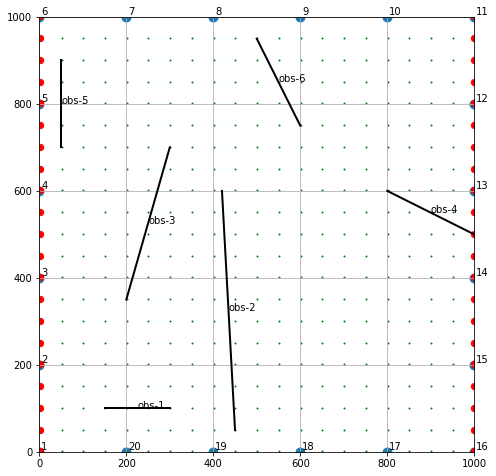

Meas Data file ('data\deployment_1\traj_99\meas_data_99.csv') ALREADY exists...
Meas DataOut file ('data\deployment_1\traj_99\meas_data_out_99.csv') ALREADY exists...
Estimated Position file ('data\deployment_1\traj_99\est_pos_99.csv') ALREADY exists...


In [3]:
deploymentIdx = 1
trajIdx = 99
verbosity = 2
SPEED = 50 if trajIdx==99 else 10

truthCsvFname,measOutCsvFname,estPosCsvFname = mhf.generateRealTimeMeasurements(deploymentIdx, trajIdx, verbosity, speed=SPEED)

txPosCsvFname = "data\\deployment_{0!s}\\{1}.csv".format(deploymentIdx, "txpos")
obsCsvFname = "data\\deployment_{0!s}\\{1}.csv".format(deploymentIdx, "obstacles")
trajCsvFname = "data\\deployment_{0!s}\\{2}_{1!s}.csv".format(deploymentIdx, trajIdx, "waypoints")


In [4]:
dft = pd.read_csv(truthCsvFname)
print("Reading file {}...".format(truthCsvFname))
dft.info()
pxy = dft.loc[:,['x','y']].values
dft.head()

Reading file data\deployment_1\traj_99\truth_99.csv...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441 entries, 0 to 440
Data columns (total 3 columns):
timestamp    441 non-null float64
x            441 non-null float64
y            441 non-null float64
dtypes: float64(3)
memory usage: 10.4 KB


,timestamp,x,y
0,0.0,1.0,1.0
1,1.0,51.0,1.0
2,2.0,101.0,1.0
3,3.0,151.0,1.0
4,4.0,201.0,1.0


In [5]:
df = pd.read_csv(txPosCsvFname)
print("Reading file {}...".format(txPosCsvFname))
df.info()
txy = df.loc[:].values
df.head()

Reading file data\deployment_1\txpos.csv...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
id    20 non-null int64
x     20 non-null int64
y     20 non-null int64
dtypes: int64(3)
memory usage: 560.0 bytes


,id,x,y
0,1,0,0
1,2,0,200
2,3,0,400
3,4,0,600
4,5,0,800


In [6]:
df = pd.read_csv(obsCsvFname)
print("Reading file {}...".format(obsCsvFname))
df.info()
xyobs = np.array(df.loc[:])
df.head()

Reading file data\deployment_1\obstacles.csv...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 5 columns):
id    6 non-null int64
x1    6 non-null int64
y1    6 non-null int64
x2    6 non-null int64
y2    6 non-null int64
dtypes: int64(5)
memory usage: 320.0 bytes


,id,x1,y1,x2,y2
0,1,150,100,300,100
1,2,450,50,420,600
2,3,200,350,300,700
3,4,1000,500,800,600
4,5,50,700,50,900


In [7]:
df = pd.read_csv(measOutCsvFname)
print("Reading file {}...".format(measOutCsvFname))
df['range_residual'] = df.range - df.dlos
df.info()
df.head(10)

Reading file data\deployment_1\traj_99\meas_data_out_99.csv...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8820 entries, 0 to 8819
Data columns (total 11 columns):
timestamp         8820 non-null float64
tid               8820 non-null float64
tx                8820 non-null float64
ty                8820 non-null float64
range             8820 non-null float64
rssi              8820 non-null float64
los               8820 non-null float64
dlos              8820 non-null float64
nlos              8820 non-null float64
residual          8820 non-null float64
range_residual    8820 non-null float64
dtypes: float64(11)
memory usage: 758.0 KB


,timestamp,tid,tx,ty,range,rssi,los,dlos,nlos,residual,range_residual
0,0.0,1.0,0.0,0.0,1.0,0.840873,1.0,1.414214,0.0,-0.247787,-0.414214
1,0.0,2.0,0.0,200.0,199.0,0.070888,1.0,199.002513,0.0,-0.492795,-0.002513
2,0.0,3.0,0.0,400.0,399.0,0.050063,1.0,399.001253,0.0,-0.245467,-0.001253
3,0.0,4.0,0.0,600.0,599.0,0.040859,1.0,599.000835,0.0,-0.163438,-0.000835
4,0.0,5.0,0.0,800.0,799.0,0.035377,1.0,799.000626,0.0,-0.122501,-0.000626
5,0.0,6.0,0.0,1000.0,999.0,0.031639,1.0,999.000501,0.0,-0.097964,-0.000501
6,0.0,7.0,200.0,1000.0,1019.0,0.031332,1.0,1018.627508,0.0,-0.096176,0.372492
7,0.0,8.0,400.0,1000.0,1076.0,0.030489,1.0,1075.733238,0.0,-0.128811,0.266762
8,0.0,9.0,600.0,1000.0,-99.0,0.000000,0.0,1164.818441,0.0,0.000000,-1263.818441
9,0.0,10.0,800.0,1000.0,-99.0,0.000000,0.0,1279.219293,0.0,0.000000,-1378.219293


In [8]:
def plotRangeResContour(TNODE_IDX, pxy, nsize, df, fig):

    #idx = df[(df.tid==4) & (df.range>0)].index.tolist()
    idx = df[(df.tid==TNODE_IDX)].index.tolist()
    rng = np.array([df.iloc[idx].range])
    dlos = np.array([df.iloc[idx].dlos])
    # rng_res = rng - dlos

    TLOC = df.loc[(df.tid==TNODE_IDX)&(df.timestamp==0),['tid','tx','ty']]
    #print(TLOC)

    free_range = np.linalg.norm(pxy-txy[3,1:].transpose(),axis=1)

    rng_res = free_range
    rng_res = np.array([r-d if r>=0. else np.inf
                        for r,d in zip(rng.flatten(),dlos.flatten())])
    #print(rng_res.shape)

    X = pxy[:,0].reshape(nsize,-1)
    Y = pxy[:,1].reshape(nsize,-1)
    Z = rng_res.reshape(nsize,-1)
    
    ax = fig.gca()
    ctr = ax.contourf(X, Y, Z, np.arange(-25, 501, 25), extend='max', cmap=cm.viridis_r)#RdYlGn_r)
    fig.colorbar(ctr,ax=ax,shrink=0.75)
    
    ax.set_aspect('equal')
    ax.scatter(TLOC.tx,TLOC.ty,s=80,c='red',marker='D')
    ax.set_xlim(-100,1100)
    ax.set_ylim(-100,1100)
    ax.set_title("SV {} Range Error (m)".format(TNODE_IDX))
    ax.set_xlim(-100,1100)
    ax.set_ylim(-100,1100)


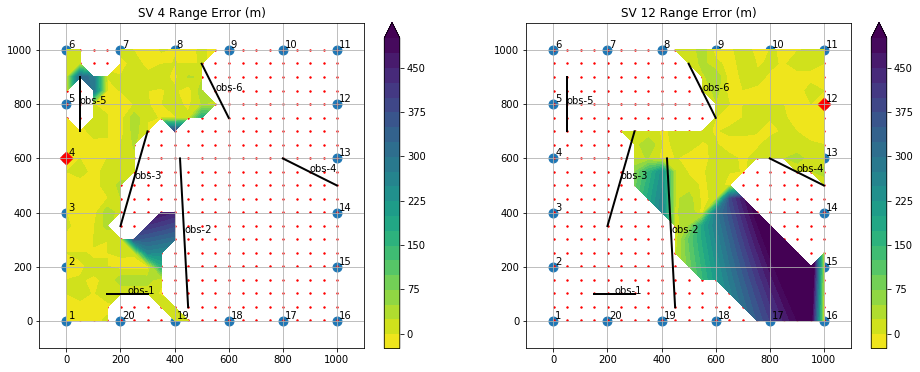

In [9]:
nsize = int(np.sqrt(pxy.shape[0]))
is_mesh = True
if nsize**2!=pxy.shape[0]:
    print("ERROR: input points data NOT a meshgrid...")
    is_mesh = False

    # else:
    #     X = pxy[:,0]
    #     Y = pxy[:,1]
    #     TH = [math.atan2(Y[i]-TLOC.ty.values, X[i]-TLOC.tx.values) for i in range(X.shape[0])]
    #     Zx,Zy = X+rng_res*np.cos(TH),Y+rng_res*np.sin(TH)

    #     fig = plt.figure(figsize=(16,8))
    #     plt.subplot(121)
    #     ax = fig.gca()

    #     Q = plt.quiver(X, Y, Zx, Zy, units='xy', scale_units='xy',
    #                    scale=QUIVER_SF, color='blue')
    #     qk = plt.quiverkey(Q, 0.9, 0.97, 100/QUIVER_SF, r'100m', labelpos='E',
    #                        color='red', coordinates='axes')
    # #    ax.scatter(exy_s[:,0],exy_s[:,1],s=2,c='green')
    #     plotDeployment(txy,pxy,xyobs,fig)
    #     ax.set_aspect('equal')
    #     ax.set_xlim(-100,1100)
    #     ax.set_ylim(-100,1100)
    #     ax.set_title("{} Filter (Scaled=1/{!s}) Error Vectors (m)".format(filt_type,QUIVER_SF))

else:
    fig = plt.figure(figsize=(16,8))
    
    plt.subplot(121)
    plotDeployment(txy,pxy,xyobs,fig)
    plotRangeResContour(4, pxy, nsize, df, fig)
    
    plt.subplot(122)
    plotDeployment(txy,pxy,xyobs,fig)
    plotRangeResContour(12, pxy, nsize, df, fig)

    plt.show()

In [10]:
df = pd.read_csv(estPosCsvFname)
filt_type = "WLS"
df.head()

,timestamp,x,y,cost,#meas,sv_used
0,0.0,-1.003267,0.021842,173.138026,13.0,"[1, 2, 3, 4, 5, 6, 7, 8, 16, 17, 18, 19, 20]"
1,1.0,47.305731,5.233057,191.647250,13.0,"[1, 2, 3, 4, 5, 6, 7, 8, 16, 17, 18, 19, 20]"
2,2.0,93.133327,-2.310527,228.617134,13.0,"[1, 2, 3, 4, 5, 6, 7, 8, 16, 17, 18, 19, 20]"
3,3.0,145.941467,-0.211172,382.168148,11.0,"[1, 2, 3, 4, 5, 6, 16, 17, 18, 19, 20]"
4,4.0,199.011061,-0.182026,1478.048405,8.0,"[1, 2, 3, 16, 17, 18, 19, 20]"


In [11]:
def plotFilterErrorContour(pxy, errn, nsize, filt_type, fig):
    
    X = pxy[:,0].reshape(nsize,-1)
    Y = pxy[:,1].reshape(nsize,-1)
    Zn = errn.reshape(nsize,nsize)
    print(X.shape,Y.shape,Zn.shape)
    
    ax = fig.gca()
    ctr = ax.contourf(X, Y, Zn, np.arange(0, 501, 25), extend='max', cmap=cm.viridis_r)
    fig.colorbar(ctr,ax=ax,shrink=0.75)
    ax.set_aspect('equal')
    ax.set_xlim(-100,1100)
    ax.set_ylim(-100,1100)
    ax.grid()
    ax.set_title("{} Filter Error Norm (m)".format(filt_type))


In [12]:

def plotFilterErrorQuiver(pxy, err, nsize, filt_type, fig, QUIVER_SF):
    
    if nsize>0:
        X = pxy[:,0].reshape(nsize,-1)
        Y = pxy[:,1].reshape(nsize,-1)
        Z = err.reshape(nsize,nsize,2)
    else:
        X = pxy[:,0]
        Y = pxy[:,1]
        Z = err.reshape(err.shape[0],1,2)
    print(X.shape,Y.shape,Z.shape)
    
    ax = fig.gca()
    Q = plt.quiver(X, Y, Z[:,:,0], Z[:,:,1], units='xy', scale_units='xy',
               scale=QUIVER_SF, color='blue')
    qk = plt.quiverkey(Q, 0.9, 0.97, 100/QUIVER_SF, r'100m', labelpos='E',
                       color='red', coordinates='axes')
    ax.scatter(exy_s[:,0],exy_s[:,1],s=2,c='green')
    plotDeployment(txy,pxy,xyobs,fig)
    ax.set_aspect('equal')
    ax.set_xlim(-100,1100)
    ax.set_ylim(-100,1100)
    ax.grid()
    ax.set_title("{} Filter (Scaled=1/{!s}) Error Vectors (m)".format(filt_type,QUIVER_SF))   

(441, 2) (441, 2) (441, 2) (441,)
(21, 21) (21, 21) (21, 21)
(21, 21) (21, 21) (21, 21, 2)


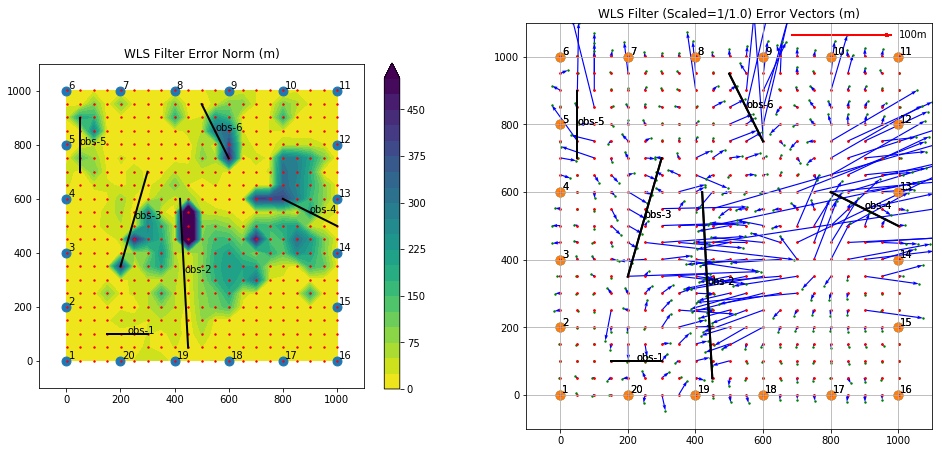

In [13]:
exy = df.loc[:,['x','y']].values
err = exy - pxy
errn = np.linalg.norm(err,axis=1)

QUIVER_SF = 1.0
exy_s =  pxy + (1/QUIVER_SF) * err

print(exy.shape,pxy.shape,err.shape,errn.shape)

if nsize**2!=pxy.shape[0]:
    print("ERROR: input points data NOT a meshgrid...")
    is_mesh = False
    
    fig = plt.figure(figsize=(16,8))
    plt.subplot(121)
    plotDeployment(txy,pxy,xyobs,fig)
    plotFilterErrorQuiver(pxy, err, -1, filt_type, fig, QUIVER_SF)
    
else:
    fig = plt.figure(figsize=(16,8))
    plt.subplot(121)
    plotFilterErrorContour(pxy, errn, nsize, filt_type, fig)
    plotDeployment(txy,pxy,xyobs,fig)

    plt.subplot(122)
    plotDeployment(txy,pxy,xyobs,fig)
    plotFilterErrorQuiver(pxy, err, nsize, filt_type, fig, QUIVER_SF)

    plt.show()
    # ax.view_init(90, -90)

